<a href="https://colab.research.google.com/github/gmihaila/stock_risk_prediction/blob/master/notebooks/train_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Info

* Main Dataset: [S&P 500 stock data](https://www.kaggle.com/camnugent/sandp500)

* Download detailes for each company: [S&P 500 Companies with Financial Information](https://datahub.io/core/s-and-p-500-companies-financials#resource-s-and-p-500-companies-financials_zip)

Stock prices are flutuated in every day. So, in each day, put those stocks in order of price change to one sentence. Then, with certain window size, each stock will show up with highly related stock frequently, because they tend to move their prices together. Source: [stock2vec repo](https://github.com/kh-kim/stock2vec)

# Imports

In [1]:
import pandas as pd
import numpy as np
import operator
import sys
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.patches as mpatches
import seaborn as sns

# Helper Functions

In [2]:
def sort_dict(mydict, reversed=False):
  return sorted(mydict.items(), key=operator.itemgetter(1), reverse=reversed)

# Read Data

In [3]:
# emission details
emissions_df = pd.read_csv('../notebooks/content/emission.csv')
print(emissions_df.head())

   Unnamed: 0 symbol              company                  sector   price  \
0           0    MMM           3M Company             Industrials  222.89   
1           1    AOS      A.O. Smith Corp             Industrials   60.24   
2           2    ABT  Abbott Laboratories             Health Care   56.27   
3           3   ABBV          AbbVie Inc.             Health Care  108.48   
4           4    ACN        Accenture plc  Information Technology  150.51   

   price_per_earnings  dividend_yield  earnings_per_share  52_week_low  \
0               24.31        2.332862                7.92       259.77   
1               27.76        1.147959                1.70        68.39   
2               22.51        1.908982                0.26        64.60   
3               19.41        2.499560                3.29       125.86   
4               25.47        1.714470                5.44       162.60   

   52_week_high    market_cap  esg_rating  
0       175.490  1.387210e+11        34.9  
1   

# Preprocess

In [4]:
# dicitonary for companies name and sector
companies_names = {symbol:name for symbol, name in emissions_df[['symbol', 'company']].values}
companies_sector = {symbol:sector for symbol, sector in emissions_df[['symbol', 'sector']].values}

# get all companies symbols
symbols = emissions_df['company'].values

In [5]:
companies_sector

{'MMM': 'Industrials',
 'AOS': 'Industrials',
 'ABT': 'Health Care',
 'ABBV': 'Health Care',
 'ACN': 'Information Technology',
 'ATVI': 'Information Technology',
 'AYI': 'Industrials',
 'ADBE': 'Information Technology',
 'AAP': 'Consumer Discretionary',
 'AMD': 'Information Technology',
 'AES': 'Utilities',
 'AMG': 'Financials',
 'AFL': 'Financials',
 'A': 'Health Care',
 'APD': 'Materials',
 'AKAM': 'Information Technology',
 'ALK': 'Industrials',
 'ALB': 'Materials',
 'ARE': 'Real Estate',
 'ALXN': 'Health Care',
 'ALGN': 'Health Care',
 'ALLE': 'Industrials',
 'AGN': 'Health Care',
 'ADS': 'Information Technology',
 'LNT': 'Utilities',
 'ALL': 'Financials',
 'GOOGL': 'Information Technology',
 'MO': 'Consumer Staples',
 'AMZN': 'Consumer Discretionary',
 'AEE': 'Utilities',
 'AAL': 'Industrials',
 'AEP': 'Utilities',
 'AXP': 'Financials',
 'AIG': 'Financials',
 'AMT': 'Real Estate',
 'AWK': 'Utilities',
 'AMP': 'Financials',
 'ABC': 'Health Care',
 'AME': 'Industrials',
 'AMGN': 'He

# Data for Word Embeddings

For each date in out dataset we rearrange each company in ascending order based on the **change in price**.

Formula for **change in price** [source](https://pocketsense.com/calculate-market-price-change-common-stock-4829.html):
* (closing_price - opening_price) / opening_price

We can change the formula to use highest price and lowest price. This is something we will test out.

In [6]:
len(companies_sector)

461

In [12]:
# calculate price change for each stock and sort them in each day
for date, symbol, op, cl, in stocks_df[['date', 'Name', 'open', 'close']].values:
  # CHANGE IN PRICE: (closing_price - opening_price) / opening_price
  dates_dictionary[date][symbol] = (cl - op)/op
# sort each day reverse order
dates_dictionary = {date:sort_dict(dates_dictionary[date]) for date in dates}

stocks_w2v_data = [[value[0] for value in dates_dictionary[date]] for date in dates]

# print sample
print(stocks_w2v_data[0])

NameError: name 'stocks_df' is not defined

In [ ]:
em

# Train Word Embeddings

In [13]:
def hash(astring):
   return ord(astring[0])

In [14]:
stocks_ordered = [[value[0] for value in dates_dictionary[date]] for date in dates]
def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=class_names)
    fig, ax = pyplot.subplots(figsize=(20, 15)) 
    ax = sns.heatmap(
        cm, 
        annot=True, 
        fmt="d", 
        cmap=sns.diverging_palette(230, 30, n=9),
        ax=ax,
        annot_kws={"fontsize":20}
    )
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    pyplot.ylabel('Actual', fontsize = 20)
    pyplot.xlabel('Predicted', fontsize = 20)
    ax.set_title('Confusion Matrix', fontsize = 40, y = -.02)
    ax.set_xticklabels(class_names, fontsize=20, rotation=90)
    ax.set_yticklabels(class_names, rotation=0, fontsize = 20)
    b, t = pyplot.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    pyplot.ylim(b, t) # update the ylim(bottom, top) values
    pyplot.show() # ta-da! '''

NameError: name 'dates' is not defined

this is j: 4
Word2Vec(vocab=505, size=4, alpha=0.025)
Accuracy is  0.5988023952095808


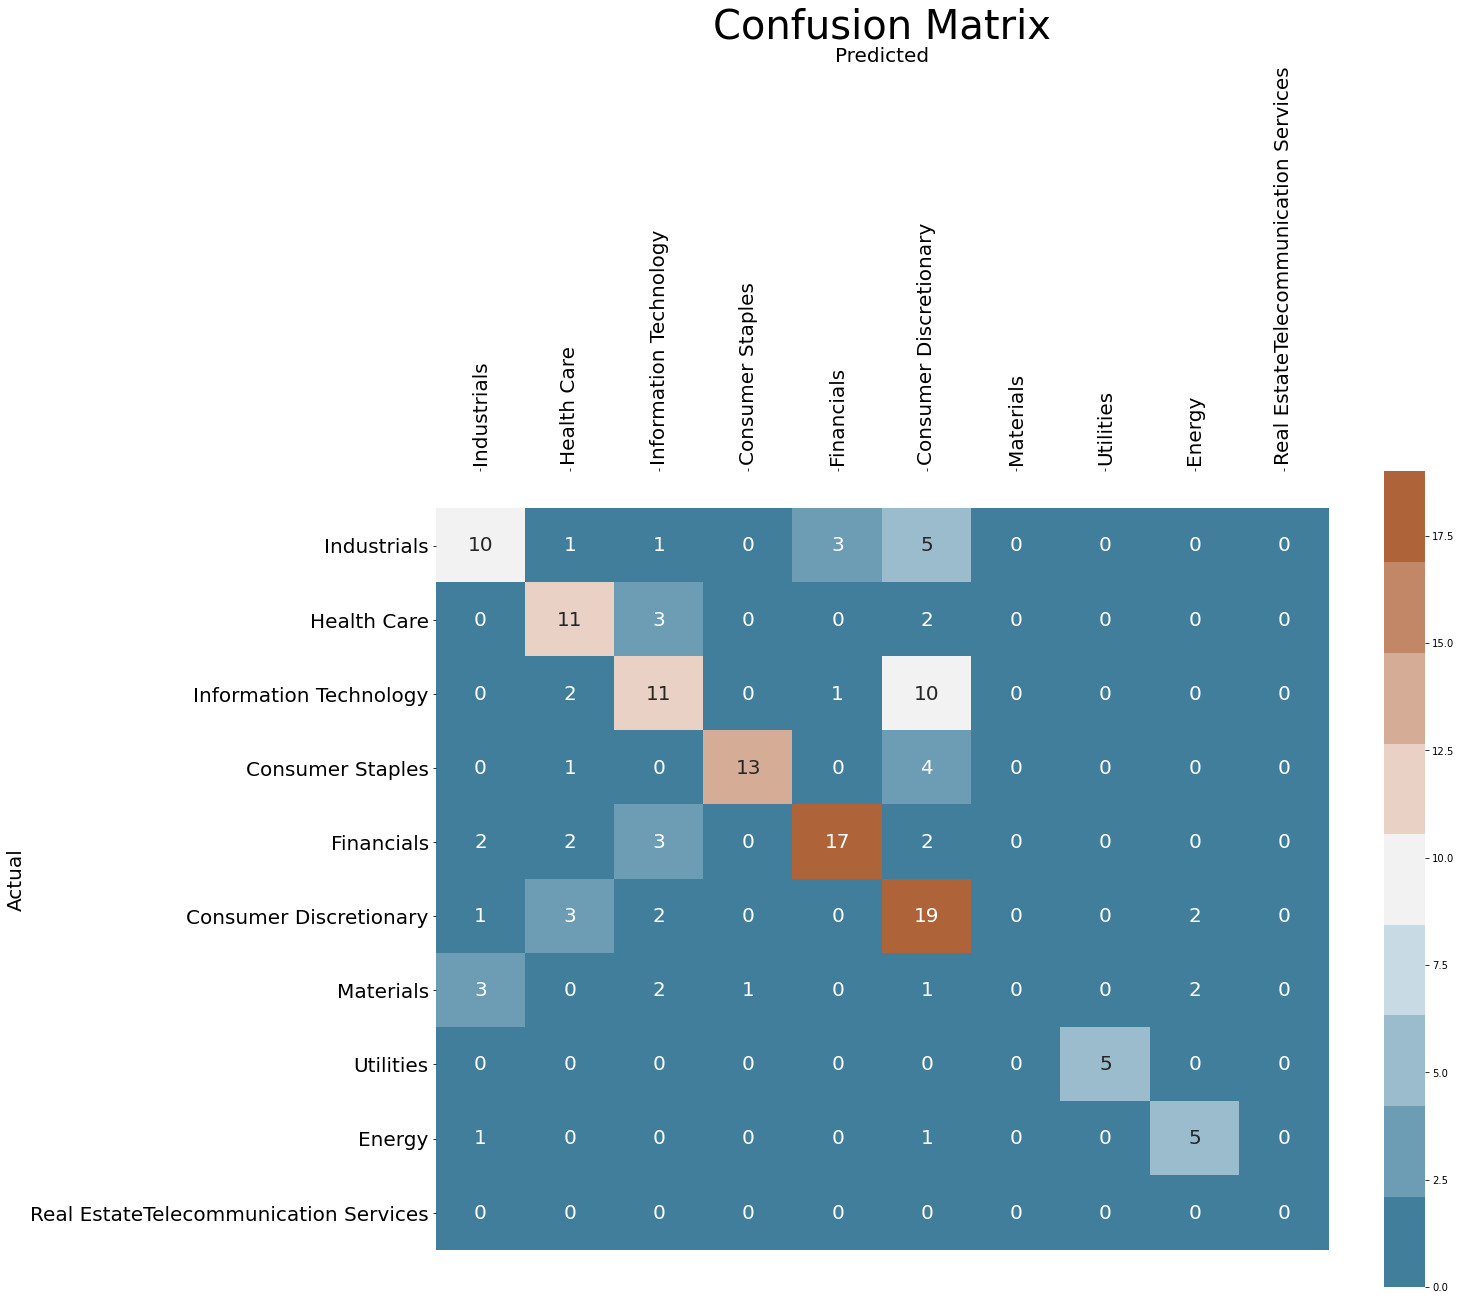

In [32]:
# train model
featureNumber = 15
labels = ['Industrials' ,'Health Care' ,'Information Technology' ,'Consumer Staples','Financials','Consumer Discretionary'
                      , 'Materials', 'Utilities','Energy', 'Real Estate'
                     'Telecommunication Services']

for j in range(4,5):
    print("this is j: " + str(j))
    model = Word2Vec(stocks_w2v_data, min_count=1, size=j)
    print(model)
    words = list(model.wv.vocab)
    X = model[model.wv.vocab]
    Y = list()
    for word in words:
        Y.append(companies_sector[word])

    train, test, train_labels, test_labels = train_test_split(X, Y, test_size=0.33, random_state=42)
    classifiers = []
    # Initialize our classifiers
    #model1 = GaussianNB()
    #classifiers.append(model1)
    model2 = svm.SVC(gamma = 1, C = 1)
    classifiers.append(model2)
    #model3 = tree.DecisionTreeClassifier()
    #classifiers.append(model3)
    #model4 = RandomForestClassifier()
    #classifiers.append(model4)
    # Train our classifier
    for clf in classifiers:
        clf.fit(train, train_labels)
        y_pred= clf.predict(test)
        acc = accuracy_score(test_labels, y_pred)
        print("Accuracy is ", acc)
        plot_cm(test_labels,y_pred,labels)
    #classifier = gnb.fit(train, train_labels)
    #preds = gnb.predict(test)
    #print(accuracy_score(test_labels, preds))

np.set_printoptions(threshold=sys.maxsize)

In [41]:
# Save Stoct2vec Vectors
binary_vectors = 'stoack2vec_Keyed_Binary.bin'
text_vectors = 'stoack2vec_Keyed_Text.vec'
stoack2vecKeyedBinary = model.wv.save_word2vec_format(fname=binary_vectors, binary=True)
stoack2vecKeyedText = model.wv.save_word2vec_format(fname=text_vectors, binary=False)

In [47]:
model.wv['TPR']

array([-0.91215605,  0.9911873 ,  0.35715806, -0.33598167], dtype=float32)

In [50]:
#binary_vectors = 'stoack2vec_Keyed_Binary2.bin'
text_vectors = 'wordvectors.kv'
#path = get_tmpfile("wordvectors.kv")
#stoack2vecKeyedBinary = model.wv.save(path)
model.wv.save(text_vectors)

In [53]:
X.shape

(505, 4)

In [56]:
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)

NameError: name 'pca' is not defined

In [77]:
words = list(model.wv.vocab)
X = model[model.wv.vocab]

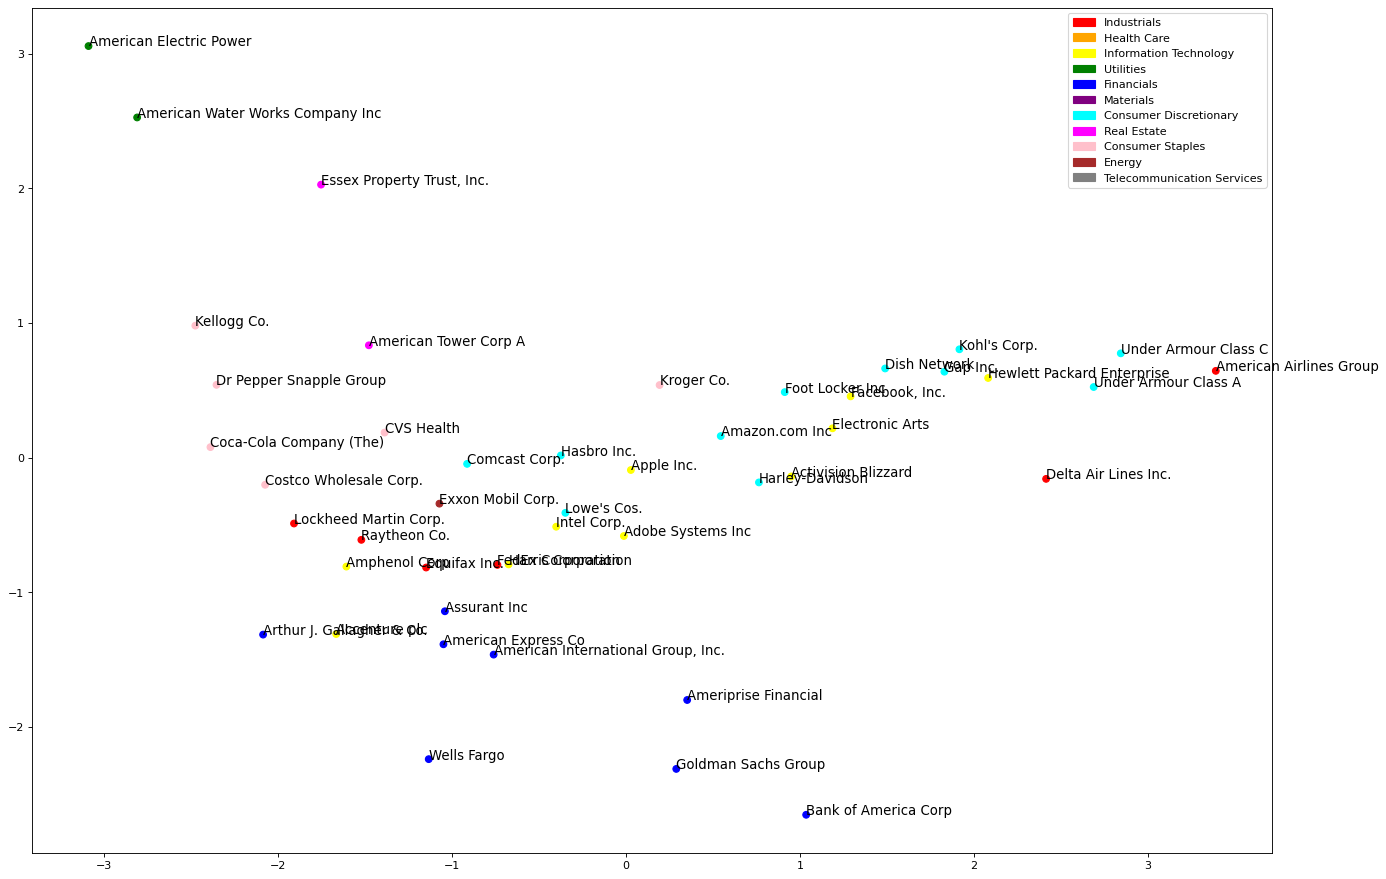

"\npca.fit(X)\neigen_vecs = pca.components_\neigen_vals = pca.explained_variance_\nprint(eigen_vals)\n# Make a list of (eigenvalue, eigenvector) tuples\neigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]\n\n# Sort the (eigenvalue, eigenvector) tuples from high to low\neigen_pairs.sort(key=lambda k: k[0], reverse=True)\n\nw = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))\n\nprint('Matrix W:\n', w)\n"

In [58]:
# fit a 2d PCA model to the vectors
words = list(model.wv.vocab)
X = model[model.wv.vocab]


pca = PCA(n_components=4)

result = pca.fit_transform(X)


'''
with open("../notebooks/output/features.txt", 'w') as featureFile:
    for i in range(0,505):
        featureFile.write(words[i])
        featureFile.write(", ")
        featureFile.write(companies_sector[words[i]])
        featureFile.write(", Feature Numbers: ")
        for j in range(0,15):
            featureFile.write(str(model[model.wv.vocab][i,j]))
            featureFile.write(" ")
        featureFile.write("\n")
'''
sectors = ['Industrials' ,'Health Care' ,'Information Technology' ,'Utilities','Financials','Materials', 
                     'Consumer Discretionary','Real Estate', 'Consumer Staples','Energy',
                     'Telecommunication Services']
'''
with open("../notebooks/output/averageFeatures.txt", 'w') as averageFile:
    for k in range(0, len(sectors)):
        companiesInSector = 0
        averages = []
        for i in range (0, featureNumber):
            averages.append(0.0)
        for i in range(0,505):
            if companies_sector[words[i]] == sectors[k]:
                companiesInSector += 1
                for j in range(0,featureNumber):
                    averages[j] += model[model.wv.vocab][i,j]
        for i in range (0,featureNumber):
            averages[i] /= companiesInSector;
        averageFile.write(sectors[k])
        averageFile.write(" Average Feature Numbers: ")
        averageFile.write("\n")
        for i in range(0, featureNumber):
            averageFile.write(str(averages[i]) + " ")
    
        averageFile.write("\n\n")
'''
newResultX = []
newResultY = []
newWords = list()
newWordToken = ""
with open('../notebooks/content/stocks.txt') as stockFile:
    contents = stockFile.read()
    for i in range(0,505):
        newWordToken = "%" + words[i] + "%"
        if newWordToken in contents:
            newWords.append(words[i])
            newResultX.append(result[i,0])
            newResultY.append(result[i,1])
#Increase Size of Figure
pyplot.figure(num=None, figsize=(20, 14), dpi=80, facecolor='w', edgecolor='k')
#Colors
sector_color_dict = {'Industrials':'red','Health Care':'orange','Information Technology':'yellow','Utilities':'green',
                     'Financials':'blue','Materials':'purple','Consumer Discretionary':'cyan','Real Estate':'magenta',
                     'Consumer Staples':'pink','Energy':'brown','Telecommunication Services':'gray'}
cvec = [sector_color_dict[companies_sector[word]] for word in newWords]
# create a scatter plot of the projection
pyplot.scatter(newResultX[:], newResultY[:], c = cvec)
#Names the Labels
for i, word in enumerate(newWords):
    pyplot.annotate(companies_names[word], xy=(newResultX[i], newResultY[i]), fontsize = 12)
#Legend
red_patch=mpatches.Patch(color='red', label='Industrials')
orange_patch=mpatches.Patch(color='orange', label='Health Care')
yellow_patch=mpatches.Patch(color='yellow', label='Information Technology')
green_patch=mpatches.Patch(color='green', label='Utilities')
blue_patch=mpatches.Patch(color='blue', label='Financials')
purple_patch=mpatches.Patch(color='purple', label='Materials')
cyan_patch=mpatches.Patch(color='cyan', label='Consumer Discretionary')
magenta_patch=mpatches.Patch(color='magenta', label='Real Estate')
pink_patch=mpatches.Patch(color='pink', label='Consumer Staples')
brown_patch=mpatches.Patch(color='brown', label='Energy')
gray_patch=mpatches.Patch(color='gray', label='Telecommunication Services')
pyplot.legend(handles=[red_patch,orange_patch,yellow_patch,green_patch,blue_patch,purple_patch,cyan_patch,magenta_patch,
                       pink_patch,brown_patch,gray_patch],loc='best')
pyplot.show()




'''
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)
'''

In [62]:
# access vector for one word
print(model['AAL'])

[-2.9156845   1.3464382   2.3512566   0.20924406]


In [66]:
target_symb = 'ALXN'

print('Symbol:%s\tName:%s\tSector: %s'%(target_symb, companies_names[target_symb], companies_sector[target_symb]))
top_similar = model.similar_by_word(target_symb, topn=20)
#top_similar = model.similar_by_vector(target_symb, topn=20)
print('Most Similar')
for similar in top_similar:
  symb = similar[0]
  name = companies_names[symb]
  sect = companies_sector[symb]
  print('Symbol: %s\tName: %s\t\t\tSector: %s'%(symb, name, sect))

Symbol:ALXN	Name:Alexion Pharmaceuticals	Sector: Health Care
Most Similar
Symbol: REGN	Name: Regeneron			Sector: Health Care
Symbol: VRTX	Name: Vertex Pharmaceuticals Inc			Sector: Health Care
Symbol: INCY	Name: Incyte			Sector: Health Care
Symbol: ILMN	Name: Illumina Inc			Sector: Health Care
Symbol: MYL	Name: Mylan N.V.			Sector: Health Care
Symbol: ALK	Name: Alaska Air Group Inc			Sector: Industrials
Symbol: AAL	Name: American Airlines Group			Sector: Industrials
Symbol: LEN	Name: Lennar Corp.			Sector: Consumer Discretionary
Symbol: QRVO	Name: Qorvo			Sector: Information Technology
Symbol: UAL	Name: United Continental Holdings			Sector: Industrials
Symbol: NFLX	Name: Netflix Inc.			Sector: Information Technology
Symbol: BIIB	Name: Biogen Inc.			Sector: Health Care
Symbol: DHI	Name: D. R. Horton			Sector: Consumer Discretionary
Symbol: PHM	Name: Pulte Homes Inc.			Sector: Consumer Discretionary
Symbol: NCLH	Name: Norwegian Cruise Line			Sector: Consumer Discretionary
Symbol: NVDA	Na

In [67]:
# access vector for one word
print(model['AAL'])

[-2.3085883 -2.5365422 -0.6068273  1.3847815]


In [64]:
print(model.vector_size)

4


In [76]:
model

In [69]:
pca.fit(X)
eigen_vecs = pca.components_
eigen_vals = pca.explained_variance_
print(eigen_vals)
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

print('Matrix W:\n', w)

[2.578161  1.5042285]
Matrix W:
 [[-0.31901464 -0.5193395 ]
 [-0.20597298  0.34604055]]


In [70]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[2.578161  1.5042285]
[0.5404254 0.3153113]
[0.5404254  0.85573673]


In [71]:
pca.components_

array([[-0.31901464, -0.5193395 , -0.03552455,  0.7919938 ],
       [-0.20597298,  0.34604055, -0.90950024,  0.1031505 ]],
      dtype=float32)

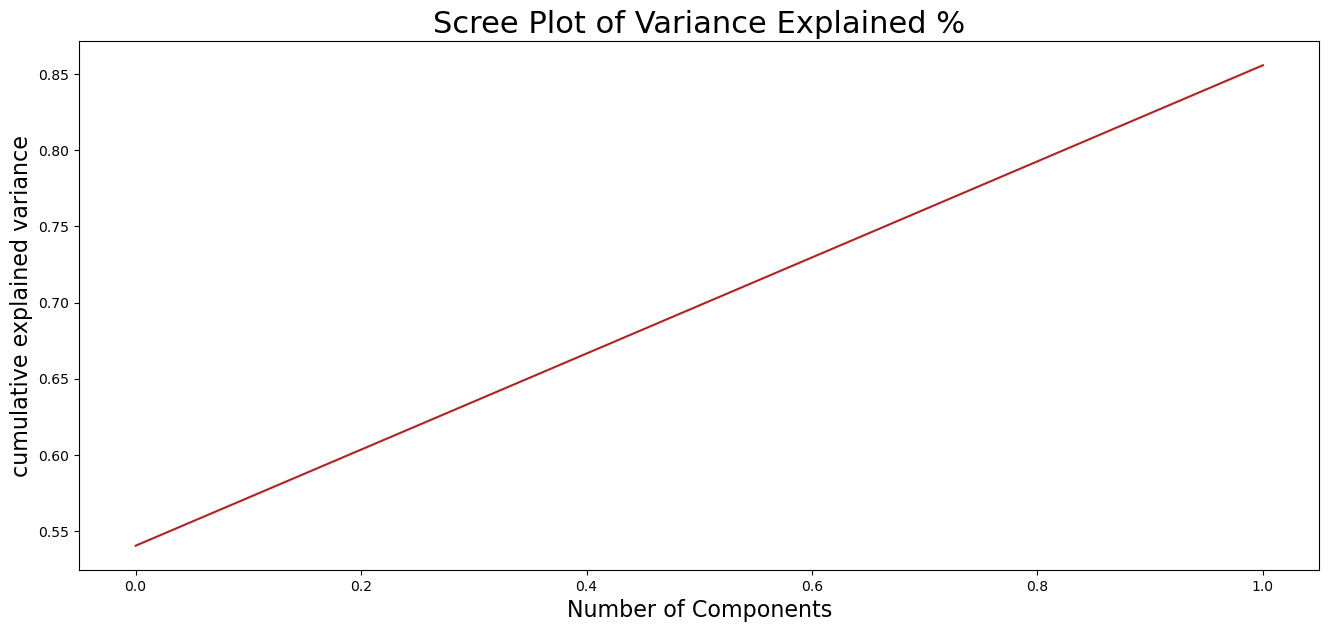

In [72]:
variance_exp_cumsum = pca.explained_variance_ratio_.cumsum()
fig, axes = pyplot.subplots(1,1,figsize=(16,7), dpi=100)
pyplot.plot(variance_exp_cumsum, color='firebrick')
pyplot.title('Scree Plot of Variance Explained %', fontsize=22)
pyplot.xlabel('Number of Components', fontsize=16)
pyplot.ylabel('cumulative explained variance', fontsize=16)
pyplot.show()

In [35]:
NUMBER_OF_COMPONENTS = 2
print("Overall")
print(pca.explained_variance_ratio_)
for component in range(NUMBER_OF_COMPONENTS):
    comp = pca.components_[component]
    print("Component %i explains ratio: %.6f" % ((component + 1),pca.explained_variance_ratio_[component]) )
    sorted_index = np.argsort(comp)

Overall
[0.5994994 0.3173974]
Component 1 explains ratio: 0.599499
Component 2 explains ratio: 0.317397


In [37]:
variance = pca.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([59.899998, 91.6     ], dtype=float32)

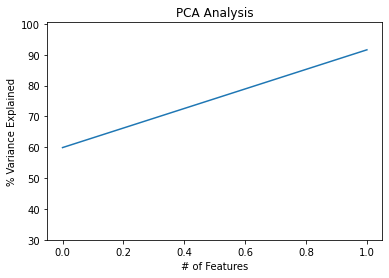

In [38]:
pyplot.ylabel('% Variance Explained')
pyplot.xlabel('# of Features')
pyplot.title('PCA Analysis')
pyplot.ylim(30,100.5)
pyplot.style.context('seaborn-whitegrid')

pyplot.plot(var)